In [3]:
"""
# Compare two control laws for the same non-adiabatic environment:
# (A) "Surprisal-only" descent: internal r and action a follow gradients of L(b,r)
# (B) "Variational" descent: internal r and action a follow gradients of F(b,r;q), with q(y|r) = N(A cos r, τ^2)
# Environment (common to both): s, y evolve with finite lags (no adiabatic closure): ds = -κ_s (s - y) dt + √(2D_s) dW, dy = -κ_y (y - a) dt + √(2D_y) dW
#
# We compare the time courses of L(b,r), F(b,r), and KL(q || p(y|s,a)).
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# Configure Matplotlib to use LaTeX for text rendering
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}", # For formatting equations
    "font.size": 11
})


# Hyperparameters
SEED       = 123
N_TRAJ     = 200        # Number of trajectories used for computing sample means
DT         = 0.002
T_TOTAL    = 8.0
SAVE_CSV   = True
SAVE_PLOTS = False       
OUTDIR     = Path(".")

# Generative model parameters
A        = 1.0
sigma_s  = 0.30
sigma_y  = 0.45
sigma_a  = 0.40
sigma_sy2 = sigma_s**2 + sigma_y**2

# Environment
kappa_s  = 7.0
kappa_y  = 7.0
D_s      = 1.0
D_y      = 1.0

# Q, Gamma parameters (dissipation for (r,a) and small solenoidal couplings)
gamma_r  = 0.8
gamma_a  = 1.0
q_rs     = 0.7
q_ra     = 0.25

# Helper maths
def posterior_stats(s, a, sigma_s, sigma_y):
    # Linear-Gaussian chain => p(y|s,a) ~ N(mu_post, V_post)
    invV   = 1.0/(sigma_s**2) + 1.0/(sigma_y**2)
    V_post = 1.0/invV
    mu_post = V_post * (s/(sigma_s**2) + a/(sigma_y**2))
    return mu_post, V_post

def L_surprisal(s, a, r):
    # L(b,r) = (s-a)^2/(2σ_sy^2) + (a - A cos r)^2/(2σ_a^2)
    return (s - a)**2 / (2.0 * sigma_sy2) + (a - A*np.cos(r))**2 / (2.0 * sigma_a**2)

def F_variational(s, a, r):
    # q(y|r) = N(m, τ^2) with τ^2 := V_post(s,a); analytic F = E_q[log term] - H[q]
    _, V_post = posterior_stats(s, a, sigma_s, sigma_y)
    m = A*np.cos(r)
    log_term = (s - m)**2 / (2.0 * sigma_s**2) + (m - a)**2 / (2.0 * sigma_y**2) + (a - m)**2 / (2.0 * sigma_a**2)
    var_term = 0.5 * V_post * (1.0/(sigma_s**2) + 1.0/(sigma_y**2))
    entropy  = 0.5 * np.log(2.0 * np.pi * np.e * V_post)
    return log_term + var_term - entropy

def KL_q_posterior(s, a, r):
    # With τ^2 = V_post, KL reduces to (m - mu_post)^2 / (2 V_post)
    mu_post, V_post = posterior_stats(s, a, sigma_s, sigma_y)
    m = A*np.cos(r)
    return (m - mu_post)**2 / (2.0 * V_post)

# Gradients for the two control laws (only r,a used to update agent; s,y evolve via environment SDE)
def grads_L(s, a, r):
    dL_dr = (A*np.sin(r)) * (a - A*np.cos(r)) / (sigma_a**2)
    dL_ds = (s - a) / sigma_sy2
    dL_da = (a - A*np.cos(r)) / (sigma_a**2) + (a - s) / sigma_sy2
    return dL_dr, dL_ds, dL_da

def grads_F(s, a, r):
    m = A*np.cos(r)
    # ∂rF = (-A sin r)[-(s-m)/σ_s^2 + (m-a)/σ_y^2] + (A sin r)(a-m)/σ_a^2
    dF_dr = (-A*np.sin(r)) * (-(s - m)/(sigma_s**2) + (m - a)/(sigma_y**2)) + (A*np.sin(r)) * (a - m)/(sigma_a**2)
    dF_ds = (s - m) / (sigma_s**2)  # used via q_rs coupling
    dF_da = (a - m) * (1.0/(sigma_y**2) + 1.0/(sigma_a**2))
    return dF_dr, dF_ds, dF_da

# Simulation
def simulate(case_name, rng, N, steps, noise_pack):
    
    # Initial ensemble
    r = rng.uniform(-np.pi, np.pi, size=N)
    s = rng.normal(0.0, 1.5, size=N)
    a = rng.normal(0.0, 1.5, size=N)
    y = rng.normal(0.0, 1.5, size=N)

    mean_L = np.empty(steps+1)
    mean_F = np.empty(steps+1)
    mean_KL = np.empty(steps+1)

    # Choose one representative sample to visualise trajectories
    idx = 0
    r_tr = np.empty(steps+1); s_tr = np.empty(steps+1); a_tr = np.empty(steps+1); y_tr = np.empty(steps+1)
    L_tr = np.empty(steps+1); F_tr = np.empty(steps+1); KL_tr = np.empty(steps+1)

    # Initial statistics
    L_vals = L_surprisal(s, a, r)
    F_vals = F_variational(s, a, r)
    KL_vals = KL_q_posterior(s, a, r)
    mean_L[0] = L_vals.mean(); mean_F[0] = F_vals.mean(); mean_KL[0] = KL_vals.mean()
    r_tr[0], s_tr[0], a_tr[0], y_tr[0] = r[idx], s[idx], a[idx], y[idx]
    L_tr[0], F_tr[0], KL_tr[0] = L_vals[idx], F_vals[idx], KL_vals[idx]

    noise_r, noise_a, noise_s, noise_y = noise_pack

    for t in range(1, steps+1):
        # Choose gradients
        if case_name == "L_only":
            dR, dS, dA = grads_L(s, a, r)
        elif case_name == "F_variational":
            dR, dS, dA = grads_F(s, a, r)
        else:
            raise ValueError("unknown case")

        # Agent updates (generalised gradient descent + curl)
        r = r + (q_rs * dS + q_ra * dA - gamma_r * dR) * DT + np.sqrt(2.0 * gamma_r * DT) * noise_r[t-1]
        a = a + (-q_ra * dR - gamma_a * dA) * DT + np.sqrt(2.0 * gamma_a * DT) * noise_a[t-1]
        r = (r + np.pi) % (2.0*np.pi) - np.pi  # wrap phase to (-pi, pi]

        # Environment updates (finite-lag sensor and external states)
        s = s + (-kappa_s * (s - y)) * DT + np.sqrt(2.0 * D_s * DT) * noise_s[t-1]
        y = y + (-kappa_y * (y - a)) * DT + np.sqrt(2.0 * D_y * DT) * noise_y[t-1]

        # Statistics
        L_vals = L_surprisal(s, a, r)
        F_vals = F_variational(s, a, r)
        KL_vals = KL_q_posterior(s, a, r)
        mean_L[t] = L_vals.mean(); mean_F[t] = F_vals.mean(); mean_KL[t] = KL_vals.mean()
        r_tr[t], s_tr[t], a_tr[t], y_tr[t] = r[idx], s[idx], a[idx], y[idx]
        L_tr[t], F_tr[t], KL_tr[t] = L_vals[idx], F_vals[idx], KL_vals[idx]

    return {
        "mean_L": mean_L, "mean_F": mean_F, "mean_KL": mean_KL,
        "r_tr": r_tr, "s_tr": s_tr, "a_tr": a_tr, "y_tr": y_tr,
        "L_tr": L_tr, "F_tr": F_tr, "KL_tr": KL_tr
    }

# Run both flows with shared noise
rng   = np.random.default_rng(SEED)
steps = int(T_TOTAL / DT)
time  = np.linspace(0.0, T_TOTAL, steps+1)

# Pre-generate identical noises for r,a,s,y to compare
noise_r = rng.normal(size=(steps, N_TRAJ))
noise_a = rng.normal(size=(steps, N_TRAJ))
noise_s = rng.normal(size=(steps, N_TRAJ))
noise_y = rng.normal(size=(steps, N_TRAJ))
noise_pack = (noise_r, noise_a, noise_s, noise_y)

out_L = simulate("L_only", rng, N_TRAJ, steps, noise_pack)
out_F = simulate("F_variational", rng, N_TRAJ, steps, noise_pack)

# Optional CSV to save
if SAVE_CSV:
    OUTDIR.mkdir(parents=True, exist_ok=True)
    df = pd.DataFrame({
        "time": time,
        "mean_L_surprisal": out_L["mean_L"],
        "mean_F_from_Lcase": out_L["mean_F"],
        "mean_KL_from_Lcase": out_L["mean_KL"],
        "mean_L_under_Fcase": out_F["mean_L"],
        "mean_F_variational": out_F["mean_F"],
        "mean_KL_variational": out_F["mean_KL"],
        "r_Lcase": out_L["r_tr"], "s_Lcase": out_L["s_tr"], "a_Lcase": out_L["a_tr"], "y_Lcase": out_L["y_tr"],
        "L_sample_Lcase": out_L["L_tr"], "F_sample_Lcase": out_L["F_tr"], "KL_sample_Lcase": out_L["KL_tr"],
        "r_Fcase": out_F["r_tr"], "s_Fcase": out_F["s_tr"], "a_Fcase": out_F["a_tr"], "y_Fcase": out_F["y_tr"],
        "L_sample_Fcase": out_F["L_tr"], "F_sample_Fcase": out_F["F_tr"], "KL_sample_Fcase": out_F["KL_tr"],
    })
    csv_path = OUTDIR / "compare_L_vs_F.csv"
    df.to_csv(csv_path, index=False)
    print("Saved CSV to:", csv_path.resolve())

# Plotting helper
def show_or_save(fig, name):
    if SAVE_PLOTS:
        OUTDIR.mkdir(parents=True, exist_ok=True)
        fig.savefig(OUTDIR / name, dpi=150, bbox_inches="tight")
        plt.close(fig)
    else:
        plt.show()

Saved CSV to: C:\Users\Dalto\compare_L_vs_F.csv


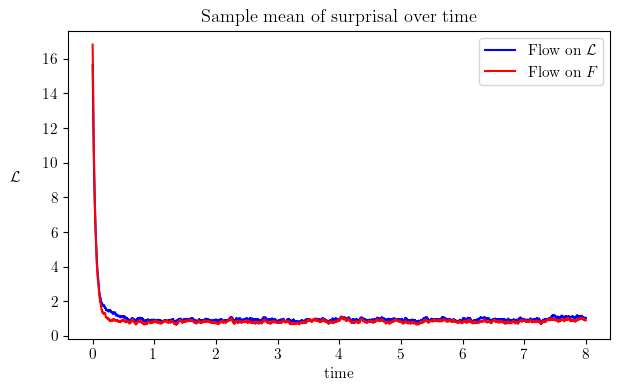

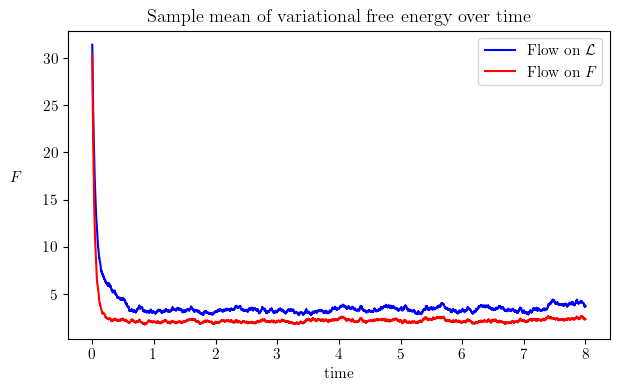

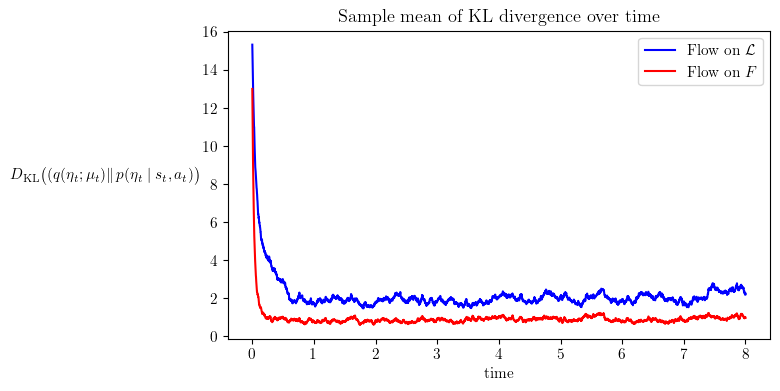

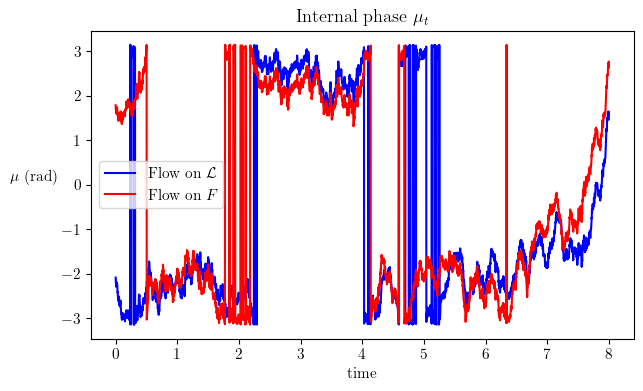

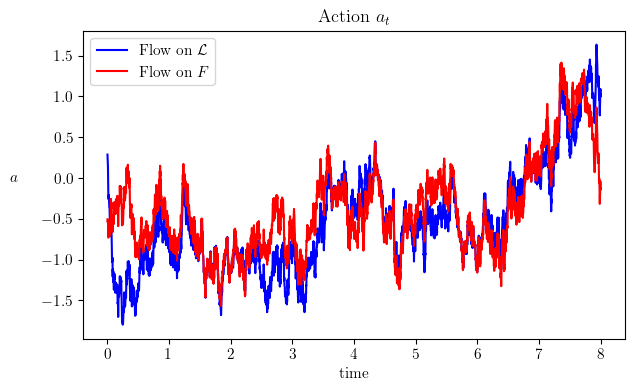

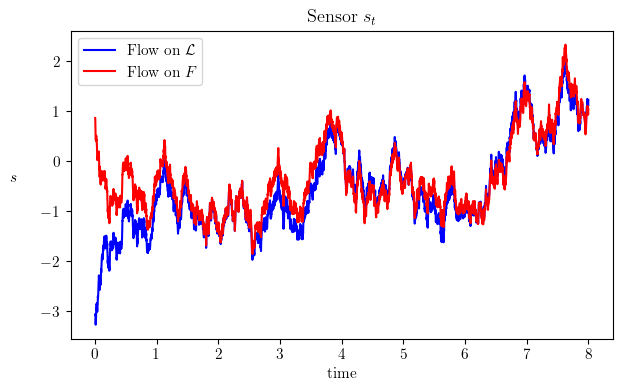

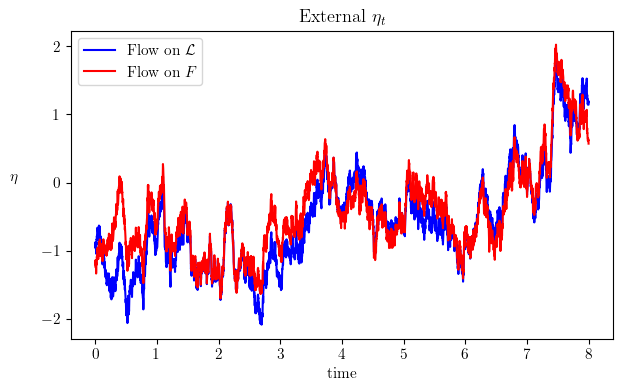

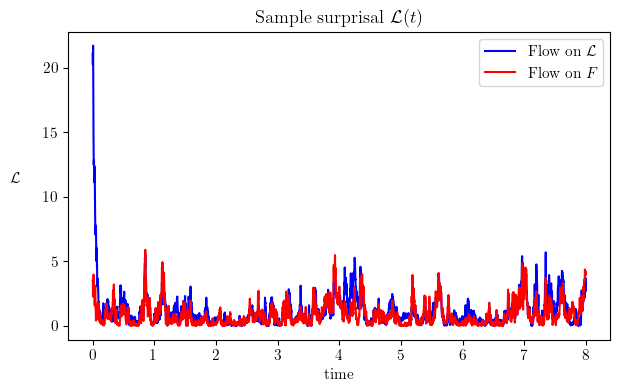

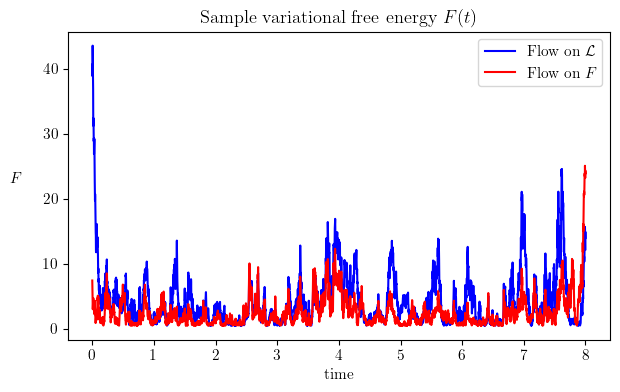

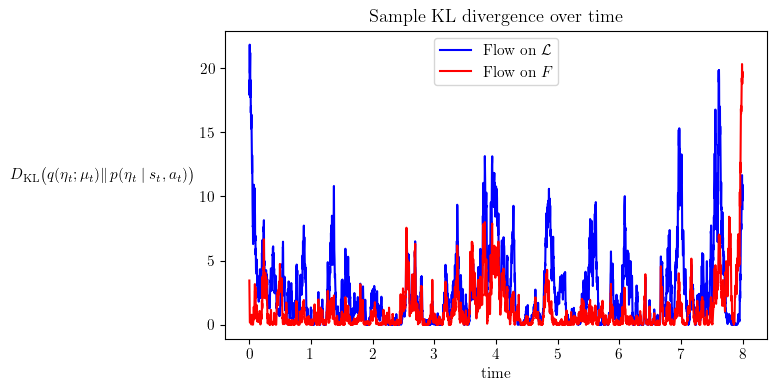

In [15]:
# Mean L
fig = plt.figure(figsize=(7,4))
plt.plot(time, out_L["mean_L"], color='blue', label="Flow on $\\mathcal{L}$")
plt.plot(time, out_F["mean_L"], color='red', label="Flow on $F$")
plt.xlabel("time"); plt.ylabel("$\\mathcal{L}$", rotation=0, labelpad=20); plt.title("Sample mean of surprisal over time"); plt.legend()
show_or_save(fig, "mean_L.svg")
fig.savefig("mean_L.svg", dpi=1200)

# Mean F
fig = plt.figure(figsize=(7,4))
plt.plot(time, out_L["mean_F"], color='blue', label="Flow on $\\mathcal{L}$")
plt.plot(time, out_F["mean_F"], color='red', label="Flow on $F$")
plt.xlabel("time"); plt.ylabel("$F$", rotation=0, labelpad=20); plt.title("Sample mean of variational free energy over time"); plt.legend()
show_or_save(fig, "mean_F.svg")
fig.savefig("mean_F.svg", dpi=1200)

# Mean KL
fig = plt.figure(figsize=(7,4))
plt.plot(time, out_L["mean_KL"], color='blue', label="Flow on $\\mathcal{L}$")
plt.plot(time, out_F["mean_KL"], color='red', label="Flow on $F$")
plt.xlabel("time"); plt.ylabel("$D_{\\mathrm{KL}}\\big((q(\\eta_t ; \\mu_t) \\| \\,p(\\eta_t \\mid s_t, a_t)\\big)$", rotation=0, labelpad=70); plt.title("Sample mean of KL divergence over time"); plt.legend()
show_or_save(fig, "mean_KL.svg")
fig.savefig("mean_KL.svg", dpi=1200)

# r(t)
fig = plt.figure(figsize=(7,4))
plt.plot(time, out_L["r_tr"], color='blue', label="Flow on $\\mathcal{L}$")
plt.plot(time, out_F["r_tr"], color='red', label="Flow on $F$")
plt.xlabel("time"); plt.ylabel("$\\mu$ (rad)", rotation=0, labelpad=20); plt.title("Internal phase $\\mu_t$"); plt.legend()
show_or_save(fig, "r_tr.svg")
fig.savefig("r_tr.svg", dpi=1200)

# a(t)
fig = plt.figure(figsize=(7,4))
plt.plot(time, out_L["a_tr"], color='blue', label="Flow on $\\mathcal{L}$")
plt.plot(time, out_F["a_tr"], color='red', label="Flow on $F$")
plt.xlabel("time"); plt.ylabel("$a$", rotation=0, labelpad=20); plt.title("Action $a_t$"); plt.legend()
show_or_save(fig, "a_tr.svg")
fig.savefig("a_tr.svg", dpi=1200)

# s(t)
fig = plt.figure(figsize=(7,4))
plt.plot(time, out_L["s_tr"], color='blue', label="Flow on $\\mathcal{L}$")
plt.plot(time, out_F["s_tr"], color='red', label="Flow on $F$")
plt.xlabel("time"); plt.ylabel("$s$", rotation=0, labelpad=20); plt.title("Sensor $s_t$"); plt.legend()
show_or_save(fig, "s_tr.svg")
fig.savefig("s_tr.svg", dpi=1200)

# y(t)
fig = plt.figure(figsize=(7,4))
plt.plot(time, out_L["y_tr"], color='blue', label="Flow on $\\mathcal{L}$")
plt.plot(time, out_F["y_tr"], color='red', label="Flow on $F$")
plt.xlabel("time"); plt.ylabel("$\\eta$", rotation=0, labelpad=20); plt.title("External $\\eta_t$"); plt.legend()
show_or_save(fig, "y_tr.svg")
fig.savefig("y_tr.svg", dpi=1200)

# Sample L(t)
fig = plt.figure(figsize=(7,4))
plt.plot(time, out_L["L_tr"], color='blue', label="Flow on $\\mathcal{L}$")
plt.plot(time, out_F["L_tr"], color='red', label="Flow on $F$")
plt.xlabel("time"); plt.ylabel("$\\mathcal{L}$", rotation=0, labelpad=20); plt.title("Sample surprisal $\\mathcal{L}(t)$"); plt.legend()
show_or_save(fig, "sample_L.svg")
fig.savefig("sample_L.svg", dpi=1200)

# Sample F(t)
fig = plt.figure(figsize=(7,4))
plt.plot(time, out_L["F_tr"], color='blue', label="Flow on $\\mathcal{L}$")
plt.plot(time, out_F["F_tr"], color='red', label="Flow on $F$")
plt.xlabel("time"); plt.ylabel("$F$", rotation=0, labelpad=20); plt.title("Sample variational free energy $F(t)$"); plt.legend()
show_or_save(fig, "sample_F.svg")
fig.savefig("sample_F.svg", dpi=1200)

# Sample KL(t)
fig = plt.figure(figsize=(7,4))
plt.plot(time, out_L["KL_tr"], color='blue', label="Flow on $\\mathcal{L}$")
plt.plot(time, out_F["KL_tr"], color='red', label="Flow on $F$")
plt.xlabel("time"); plt.ylabel("$D_{\\mathrm{KL}}\\big(q(\\eta_t ; \\mu_t) \\| \\,p(\\eta_t \\mid s_t, a_t)\\big)$", rotation=0, labelpad=70); plt.title("Sample KL divergence over time"); plt.legend()
show_or_save(fig, "sample_KL.svg")
fig.savefig("sample_KL.svg", dpi=1200)

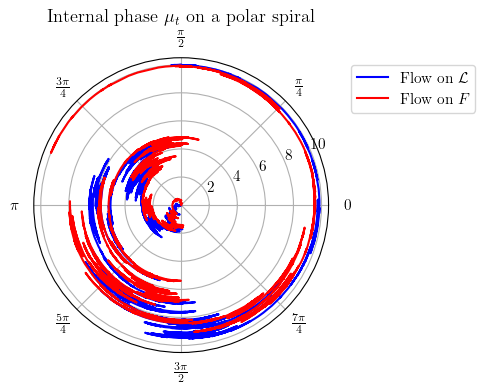

In [16]:

# --- Build polar coordinates ---
# Spiral view: radius encodes time
theta_L = np.unwrap(out_L["r_tr"])
theta_F = np.unwrap(out_F["r_tr"])
rho = 10*(time - time[0]) / (time[-1] - time[0])

fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111, projection="polar")
ax.plot(theta_L, rho, color='blue', label="Flow on $\\mathcal{L}$")
ax.plot(theta_F, rho, color='red', label="Flow on $F$")
ax.set_title("Internal phase $\\mu_t$ on a polar spiral")
ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1.0))
xtick_labels = ['0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$',
                    r'$\pi$', r'$\frac{5\pi}{4}$', r'$\frac{3\pi}{2}$', r'$\frac{7\pi}{4}$']
ax.set_xticks(np.arange(0, 2 * np.pi, np.pi / 4))
ax.set_xticklabels(xtick_labels)
plt.tight_layout()
plt.show()

fig.savefig("internal.svg", dpi=1200)


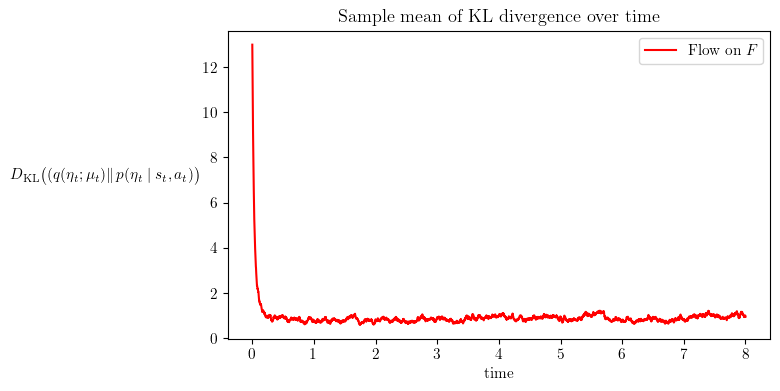

In [23]:
# Mean KL
fig = plt.figure(figsize=(7,4))
plt.plot(time, out_F["mean_KL"], color='red', label='Flow on $F$')
plt.xlabel("time"); plt.ylabel("$D_{\\mathrm{KL}}\\big((q(\\eta_t ; \\mu_t) \\| \\,p(\\eta_t \\mid s_t, a_t)\\big)$", rotation=0, labelpad=70); plt.title("Sample mean of KL divergence over time"); plt.legend()
show_or_save(fig, "mean_KL_F.svg")
fig.legend_ = None
fig.savefig("mean_KL_F.svg", dpi=1200)